In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Concatenate, Reshape
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Matiin-heidari/hotel-review-predictor/main/data/input_data.csv")
print("CSV file loaded successfully.")

CSV file loaded successfully.


In [3]:
print("Original Data Head:")
df.head()

Original Data Head:


,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
1,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
2,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
3,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
4,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review


In [4]:
print("Original Data Info:")
df.info()

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13772 entries, 0 to 13771
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hotel_Address            13772 non-null  object 
 1   Review_Date              13772 non-null  object 
 2   Average_Score            13772 non-null  float64
 3   Hotel_Name               13772 non-null  object 
 4   Reviewer_Nationality     13772 non-null  object 
 5   Hotel_number_reviews     13772 non-null  int64  
 6   Reviewer_number_reviews  13772 non-null  int64  
 7   Review_Score             13772 non-null  float64
 8   Review                   13772 non-null  object 
 9   Review_Type              13772 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.1+ MB


In [5]:
df.drop('Average_Score', axis=1, inplace=True)
print("'average_score' column dropped.")

'average_score' column dropped.


In [6]:
MAX_REVIEW_WORDS = 400
VOCAB_SIZE = 10000
EMBEDDING_DIM = 128
CONV_FILTERS = 128
KERNEL_SIZE = 5

In [7]:
# Tokenizer for Review text
review_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
review_tokenizer.fit_on_texts(df['Review'])
review_sequences = review_tokenizer.texts_to_sequences(df['Review'])
padded_review_sequences = pad_sequences(review_sequences, maxlen=MAX_REVIEW_WORDS, padding='post', truncating='post')

In [8]:
# Tokenizer for Hotel Address text
address_tokenizer = Tokenizer(num_words=VOCAB_SIZE // 2, oov_token="<unk>") # Smaller vocab for address
address_tokenizer.fit_on_texts(df['Hotel_Address'])
address_sequences = address_tokenizer.texts_to_sequences(df['Hotel_Address'])
padded_address_sequences = pad_sequences(address_sequences, maxlen=50, padding='post', truncating='post') # Max 50 words for address

In [9]:
unique_hotel_names = df['Hotel_Name'].unique()
hotel_name_to_int = {name: i for i, name in enumerate(unique_hotel_names)}
encoded_hotel_names = np.array([hotel_name_to_int[name] for name in df['Hotel_Name']])
num_hotel_names = len(unique_hotel_names)

In [10]:
unique_reviewer_nationalities = df['Reviewer_Nationality'].unique()
nationality_to_int = {nat: i for i, nat in enumerate(unique_reviewer_nationalities)}
encoded_reviewer_nationalities = np.array([nationality_to_int[nat] for nat in df['Reviewer_Nationality']])
num_nationalities = len(unique_reviewer_nationalities)

In [11]:
# Target Labels Preprocessing
# Review Type (binary: 0 for 'Bad_review', 1 for 'Good_review')
review_type_labels = (df['Review_Type'] == 'Good_review').astype(int).values.reshape(-1, 1)

# Review Score (already float, just needs to be an array)
review_score_labels = df['Review_Score'].values

In [12]:
indices = np.arange(len(df))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

In [13]:
X_inputs = {
    'review_input': padded_review_sequences,
    'address_input': padded_address_sequences,
    'hotel_name_input': encoded_hotel_names.reshape(-1, 1), # Reshape for Embedding layer input
    'nationality_input': encoded_reviewer_nationalities.reshape(-1, 1), # Reshape for Embedding layer input
    'numerical_input': df[['Hotel_number_reviews', 'Reviewer_number_reviews']].values # Unscaled numerical features
}

y_outputs = {
    'review_type_output': review_type_labels,
    'review_score_output': review_score_labels
}


In [14]:
X_train = {name: data[train_indices] for name, data in X_inputs.items()}
X_test = {name: data[test_indices] for name, data in X_inputs.items()}

y_train = {name: data[train_indices] for name, data in y_outputs.items()}
y_test = {name: data[test_indices] for name, data in y_outputs.items()}

In [15]:
# Numerical Preprocessing (Applied AFTER Split)
# Hotel number reviews, Reviewer number reviews
scaler = MinMaxScaler()
# Fit scaler ONLY on training data
scaler.fit(X_train['numerical_input'])

# Transform both training and test data
X_train['numerical_input'] = scaler.transform(X_train['numerical_input'])
X_test['numerical_input'] = scaler.transform(X_test['numerical_input'])


In [16]:
print("Data Split and Numerical Features Scaled Correctly.")
print(f"Shape of X_train['numerical_input']: {X_train['numerical_input'].shape}")
print(f"Shape of X_test['numerical_input']: {X_test['numerical_input'].shape}")

Data Split and Numerical Features Scaled Correctly.
Shape of X_train['numerical_input']: (11017, 2)
Shape of X_test['numerical_input']: (2755, 2)


In [20]:
# Model Architecture

def create_hotel_review_model(
    vocab_size_review, max_review_len, embedding_dim_review,
    vocab_size_address, max_address_len, embedding_dim_address,
    num_hotel_names, embedding_dim_hotel_name,
    num_nationalities, embedding_dim_nationality,
     conv_filters, kernel_size,
    num_numerical_features
):
    # Input Layers
    input_review = Input(shape=(max_review_len,), name='review_input')
    input_address = Input(shape=(max_address_len,), name='address_input')
    input_hotel_name = Input(shape=(1,), name='hotel_name_input')
    input_nationality = Input(shape=(1,), name='nationality_input')
    input_numerical = Input(shape=(num_numerical_features,), name='numerical_input')

    # Text Branch (Review)
    embedding_review = Embedding(vocab_size_review, embedding_dim_review, input_length=max_review_len)(input_review)
    conv_review = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(embedding_review)
    pool_review = GlobalMaxPooling1D()(conv_review)

    text_branch_output_review = Dense(64, activation='relu')(pool_review)

    # Text Branch (Address)
    embedding_address = Embedding(vocab_size_address, embedding_dim_address, input_length=max_address_len)(input_address)
    conv_address = Conv1D(filters=conv_filters // 2, kernel_size=3, activation='relu')(embedding_address)
    pool_address = GlobalMaxPooling1D()(conv_address)
    text_branch_output_address = Dense(32, activation='relu')(pool_address)


    # Categorical Branches (with Embedding layers)
    embedding_hotel_name = Embedding(num_hotel_names, embedding_dim_hotel_name, input_length=1)(input_hotel_name)
    flat_hotel_name = Reshape((embedding_dim_hotel_name,))(embedding_hotel_name)

    embedding_nationality = Embedding(num_nationalities, embedding_dim_nationality, input_length=1)(input_nationality)
    flat_nationality = Reshape((embedding_dim_nationality,))(embedding_nationality)


    # Numerical Branch
    numerical_branch_output = Dense(32, activation='relu')(input_numerical)

    # Concatenate All Branches
    concatenated = Concatenate()([
        text_branch_output_review,
        text_branch_output_address,
        flat_hotel_name,
        flat_nationality,
        numerical_branch_output
    ])

    # Shared Dense Layers
    shared_dense_1 = Dense(128, activation='relu')(concatenated)
    shared_dense_2 = Dense(64, activation='relu')(shared_dense_1)

    # Output for Review Type (Classification)
    output_review_type = Dense(1, activation='sigmoid', name='review_type_output')(shared_dense_2)

    # Output for Review Score (Regression)
    output_review_score = Dense(1, activation='linear', name='review_score_output')(shared_dense_2)

    # Create the model
    model = Model(
        inputs=[
            input_review,
            input_address,
            input_hotel_name,
            input_nationality,
            input_numerical
        ],
        outputs=[output_review_type, output_review_score]
    )

    return model

In [21]:
# Instantiate the model
model = create_hotel_review_model(
    vocab_size_review=VOCAB_SIZE, max_review_len=MAX_REVIEW_WORDS, embedding_dim_review=EMBEDDING_DIM,
    vocab_size_address=VOCAB_SIZE // 2, max_address_len=50, embedding_dim_address=EMBEDDING_DIM // 2,
    num_hotel_names=num_hotel_names, embedding_dim_hotel_name=16,
    num_nationalities=num_nationalities, embedding_dim_nationality=8,
     conv_filters=CONV_FILTERS, kernel_size=KERNEL_SIZE,
    num_numerical_features=X_train['numerical_input'].shape[1]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ review_input        │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ address_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 400, 128)  │  1,280,000 │ review_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 50, 64)    │    320,000 │ address_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 396, 128)  │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 48, 64)    │     12,352 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hotel_name_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nationality_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 16)     │     21,856 │ hotel_name_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 8)      │      1,184 │ nationality_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 16)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8)         │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         96 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 152)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],  

 Total params: 1,755,842 (6.70 MB)

 Trainable params: 1,755,842 (6.70 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
LOSS_WEIGHTS = {'review_type_output': 0.5, 'review_score_output': 0.5}

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'review_type_output': 'binary_crossentropy',
        'review_score_output': 'mse'
    },
    loss_weights=LOSS_WEIGHTS,
    metrics={
        'review_type_output': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()],
        'review_score_output': ['mae', tf.keras.metrics.RootMeanSquaredError()]
    }
)

In [28]:
# Model Training
print("Starting conceptual training loop...")
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Starting conceptual training loop...
Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 5.4211 - review_score_output_loss: 10.2483 - review_score_output_mae: 2.2622 - review_score_output_root_mean_squared_error: 2.9657 - review_type_output_accuracy: 0.6479 - review_type_output_f1_score: 0.6686 - review_type_output_loss: 0.5938 - review_type_output_precision: 0.6192 - review_type_output_recall: 0.6404 - val_loss: 0.9431 - val_review_score_output_loss: 1.6668 - val_review_score_output_mae: 0.9819 - val_review_score_output_root_mean_squared_error: 1.2788 - val_review_type_output_accuracy: 0.9011 - val_review_type_output_f1_score: 0.6683 - val_review_type_output_loss: 0.2565 - val_review_type_output_precision: 0.8712 - val_review_type_output_recall: 0.9421
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7571 - review_score_output_loss: 1.3071 - review_score_output_mae: 0.8856 - review_score_output_root_mean_squared_error: 1.1431 - review_type_output_accuracy: 0.9228 

In [24]:
# K-Fold Cross-Validation for robust evaluation
print("Performing K-Fold Cross-Validation:")
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_results = []
for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"Fold {fold + 1}/{n_splits}")

    X_train_fold_raw = {name: data[train_idx] for name, data in X_inputs.items()}
    X_val_fold_raw = {name: data[val_idx] for name, data in X_inputs.items()}

    fold_scaler = MinMaxScaler()
    fold_scaler.fit(X_train_fold_raw['numerical_input'])
    X_train_fold_raw['numerical_input'] = fold_scaler.transform(X_train_fold_raw['numerical_input'])
    X_val_fold_raw['numerical_input'] = fold_scaler.transform(X_val_fold_raw['numerical_input'])

    y_train_fold = {name: data[train_idx] for name, data in y_outputs.items()}
    y_val_fold = {name: data[val_idx] for name, data in y_outputs.items()}

    fold_model = create_hotel_review_model(
        vocab_size_review=VOCAB_SIZE, max_review_len=MAX_REVIEW_WORDS, embedding_dim_review=EMBEDDING_DIM,
        vocab_size_address=VOCAB_SIZE // 2, max_address_len=50, embedding_dim_address=EMBEDDING_DIM // 2,
        num_hotel_names=num_hotel_names, embedding_dim_hotel_name=16,
        num_nationalities=num_nationalities, embedding_dim_nationality=8,
        conv_filters=CONV_FILTERS, kernel_size=KERNEL_SIZE,
        num_numerical_features=X_train_fold_raw['numerical_input'].shape[1]
    )
    fold_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'review_type_output': 'binary_crossentropy',
            'review_score_output': 'mse'
        },
        loss_weights=LOSS_WEIGHTS,
        metrics={
            'review_type_output': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()],
            'review_score_output': ['mae', tf.keras.metrics.RootMeanSquaredError()]
        }
    )

    fold_model.fit(
        X_train_fold_raw, y_train_fold,
        epochs=3,
        batch_size=32,
        verbose=0
    )

    val_results = fold_model.evaluate(X_val_fold_raw, y_val_fold, verbose=0)
    fold_results.append(val_results)
    print(f"Fold {fold + 1} Validation Results: {val_results}")


Performing K-Fold Cross-Validation:
Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 1 Validation Results: [0.8776828646659851, 0.2462371587753296, 1.5691453218460083, 0.9475605487823486, 1.2331438064575195, 0.9070780277252197, 0.6580613255500793, 0.8953068852424622, 0.9178386330604553]
Fold 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 2 Validation Results: [0.8396323323249817, 0.2159658670425415, 1.4560365676879883, 0.913964569568634, 1.2099529504776, 0.9147005677223206, 0.673886775970459, 0.885506272315979, 0.9557142853736877]
Fold 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 3 Validation Results: [0.8576414585113525, 0.25188392400741577, 1.4698057174682617, 0.9422391057014465, 1.2134207487106323, 0.9023239016532898, 0.6595278382301331, 0.8986784219741821, 0.9033210277557373]
Fold 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 4 Validation Results: [0.879111111164093, 0.24603328108787537, 1.4989373683929443, 0.9543695449829102, 1.229331612586975, 0.8994190096855164, 0.6627821922302246, 0.9191063046455383, 0.8739926815032959]
Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 5 Validation Results: [1.3141860961914062, 0.22167736291885376, 2.438739538192749, 1.3002852201461792, 1.5507105588912964, 0.918663740158081, 0.6781857013702393, 0.8971275687217712, 0.9504600167274475]


In [25]:
if fold_results:
    mean_results = np.mean(fold_results, axis=0)
    print(f"\nMean K-Fold Validation Results: {mean_results}")


Mean K-Fold Validation Results: [0.95365077 0.23635952 1.6865329  1.0116838  1.28731194 0.90843705
 0.66648877 0.89914509 0.92026533]


In [29]:
print("Generating Predictions for Evaluation Plots")

y_pred = model.predict(X_test)
y_pred_type = (y_pred[0] > 0.5).astype(int).flatten()
y_pred_score = y_pred[1].flatten()


Generating Predictions for Evaluation Plots
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Confusion Matrix for Review Type (Classification)


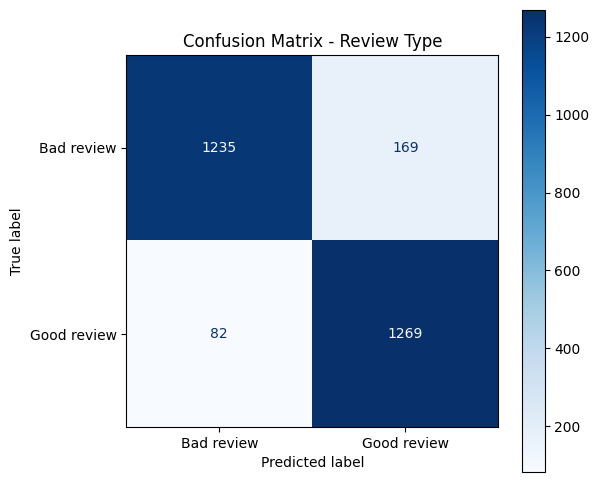

In [30]:
# Plotting Confusion Matrix for Review Type
print("Confusion Matrix for Review Type (Classification)")
cm = confusion_matrix(y_test['review_type_output'], y_pred_type)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad review', 'Good review'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix - Review Type')
plt.show()


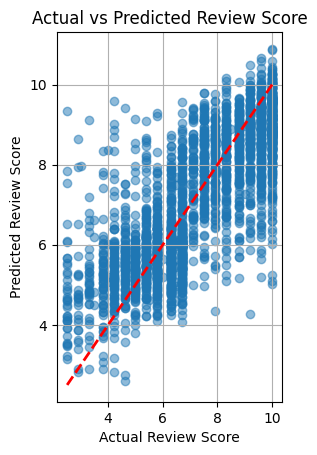

In [34]:
# Plot 1: Predicted vs Actual Values
plt.subplot(1, 2, 1)
plt.scatter(y_test['review_score_output'], y_pred_score, alpha=0.5)
plt.plot([y_test['review_score_output'].min(), y_test['review_score_output'].max()],
         [y_test['review_score_output'].min(), y_test['review_score_output'].max()],
         'r--', lw=2)
plt.xlabel('Actual Review Score')
plt.ylabel('Predicted Review Score')
plt.title('Actual vs Predicted Review Score')
plt.grid(True)

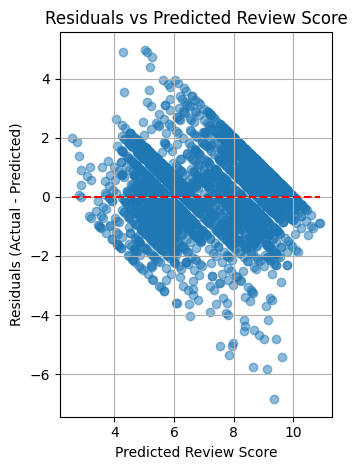

In [35]:
# Calculate residuals
residuals = y_test['review_score_output'] - y_pred_score


plt.subplot(1, 2, 2)
plt.scatter(y_pred_score, residuals, alpha=0.5)
plt.hlines(0, y_pred_score.min(), y_pred_score.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Review Score')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Review Score')
plt.grid(True)

plt.tight_layout()
plt.show()
